# predict

### setup

In [17]:
#configure for local mimic databse
exec(open("../configs/configure_mimic.py").read())
exec(open("my_functions.py").read())

#Global vars
CV=4


Configured for local MIMIC database:
	user = postgres
	dbname = mimic
	host = localhost
	schema_name = mimiciii
	query_schema = SET search_path to mimiciii;


## load sets

In [18]:
import joblib
X_train = joblib.load(open('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/X_train.joblib', 'rb'))
y_train = joblib.load(open('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/y_train.joblib', 'rb'))
X_test = joblib.load(open('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/X_test.joblib', 'rb'))
y_test = joblib.load(open('/Users/grovesdixon/projects/Insight/icu_project/my_mimic/y_test.joblib', 'rb'))

In [19]:
#lasso logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
log_reg = LogisticRegressionCV(max_iter=1000,
#                                solver='liblinear',
                                 scoring='recall',
                               n_jobs=4)

#train
log_reg.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=1000, multi_class='auto', n_jobs=4, penalty='l2',
                     random_state=None, refit=True, scoring='recall',
                     solver='lbfgs', tol=0.0001, verbose=0)

### logistic regression cross validation performance

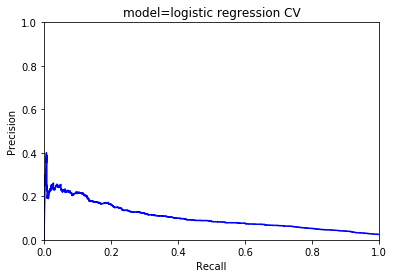

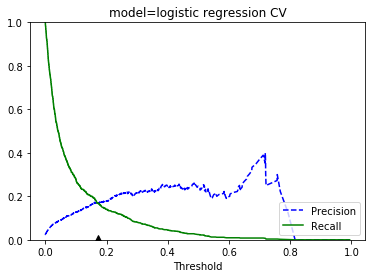

Confusion matrix for threshold = 0.17:
[[33590   714]
 [  715   145]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     34304
           1       0.17      0.17      0.17       860

    accuracy                           0.96     35164
   macro avg       0.57      0.57      0.57     35164
weighted avg       0.96      0.96      0.96     35164



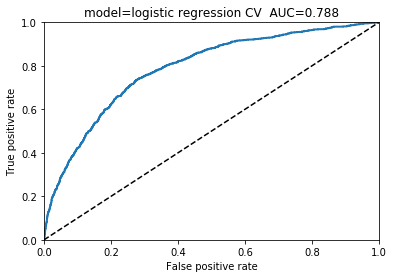

In [20]:
#logistic regression cross validation
probs_log_cv = cross_val_predict(log_reg, X_train, y_train, cv=CV, method="predict_proba", n_jobs=3)
scores_log_cv = probs_log_cv[:, 1]
log_perf_cv = get_model_performance('logistic regression CV', X_train, scores_log_cv, y_train, pos_label=1)

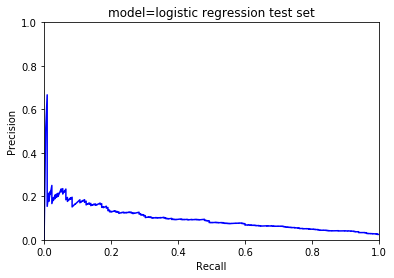

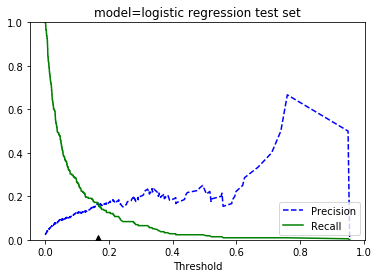

Confusion matrix for threshold = 0.17:
[[8399  178]
 [ 179   36]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8577
           1       0.17      0.17      0.17       215

    accuracy                           0.96      8792
   macro avg       0.57      0.57      0.57      8792
weighted avg       0.96      0.96      0.96      8792



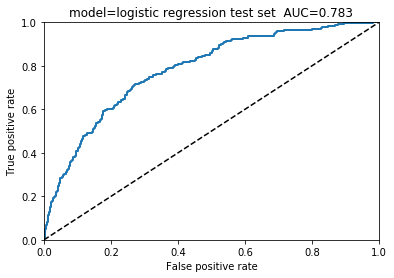

In [21]:
#performance on the test set
probs_test = log_reg.predict_proba(X_test)
scores_test = probs_test[:, 1]
test_perf = get_model_performance('logistic regression test set', X_test, scores_test, y_test, pos_label=1)

In [22]:
print(log_perf_cv['auc'])

0.788


## Random forest

In [24]:
#------- OPTIMIZE RF
RAND_SEED=321
N_JOBS=1
#use RandomizedSearchCV() to optimized Random forest hyperparameters
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf_clf = RandomForestClassifier()

#choose parameter grid values
max_depth = [20, 30, 40, 50, 75, 100]
min_samples_split = [2]
min_samples_leaf = [1]

#make grid dict
random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}


# ### run random search
rf_search = RandomizedSearchCV(estimator = rf_clf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               scoring = 'precision',
                               cv = 4,
                               verbose=2,
                               random_state=RAND_SEED,
                               n_jobs = N_JOBS)
rf_search.fit(X_train, y_train)
best_params = rf_search.best_params_
print(rf_search.best_params_)


/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 6 candidates, totalling 24 fits
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=20 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.2s remaining:    0.0s


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=20, total=   5.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=20 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=20, total=   5.1s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=20 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=20, total=   5.1s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=20 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=20, total=   5.1s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=30 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=30, total=   6.1s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=30 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=30, total=   6.1s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=30 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=30, total=   6.0s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=30 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=30, total=   6.1s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=40 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=40, total=   6.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=40 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=40, total=   6.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=40 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=40, total=   6.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=40 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=40, total=   6.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=50 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=50, total=   6.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=50 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=50, total=   6.3s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=50 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=50, total=   6.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=50 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=50, total=   6.3s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=75 ...........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=75, total=   6.1s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=75 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=75, total=   6.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=75 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=75, total=   6.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=75 ...........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=75, total=   6.2s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=100 ..........
[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=100, total=   6.1s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=100 ..........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=100, total=   6.3s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=100 ..........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=100, total=   6.3s
[CV] min_samples_split=2, min_samples_leaf=1, max_depth=100 ..........


/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  2.4min finished


[CV]  min_samples_split=2, min_samples_leaf=1, max_depth=100, total=   6.3s
{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 20}


In [35]:
#best_params = {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40}

In [10]:
#set up optimized rf model based on from best_params above
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
print(best_params)
rf_opt = RandomForestClassifier(n_jobs=N_JOBS,
                                min_samples_split = best_params['min_samples_split'],
                                min_samples_leaf = best_params['min_samples_leaf'],
                                max_depth = best_params['max_depth'],
                                bootstrap = True,
                               random_state=RAND_SEED)

#train
rf_opt.fit(X_train, y_train)

{'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 40}


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
                       oob_score=False, random_state=321, verbose=0,
                       warm_start=False)

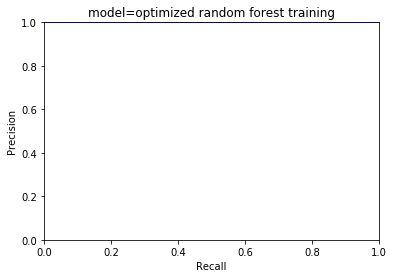

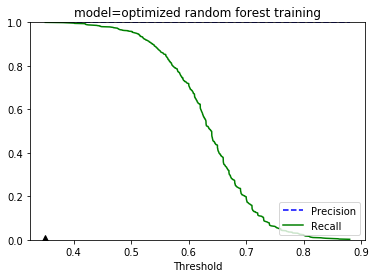

Confusion matrix for threshold = 0.35:
[[34304     0]
 [    1   859]]
Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34304
           1       1.00      1.00      1.00       860

    accuracy                           1.00     35164
   macro avg       1.00      1.00      1.00     35164
weighted avg       1.00      1.00      1.00     35164



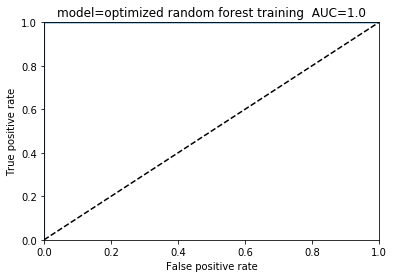

In [15]:
#optimized model performance on training set
scores_opt = rf_opt.predict_proba(X_train)[:, 1]
opt_perf = get_model_performance('optimized random forest training', X_train, scores_opt, y_train, pos_label=1)

### random forest cross validation performance

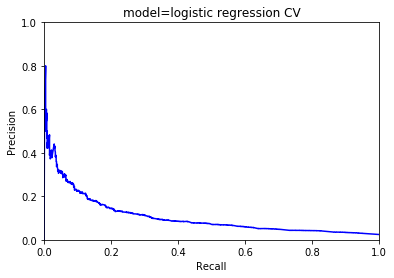

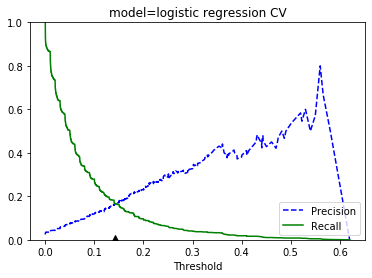

Confusion matrix for threshold = 0.14:
[[33588   716]
 [  717   143]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98     34304
           1       0.17      0.17      0.17       860

    accuracy                           0.96     35164
   macro avg       0.57      0.57      0.57     35164
weighted avg       0.96      0.96      0.96     35164



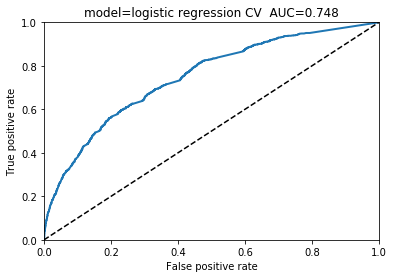

0.748


In [11]:
#logistic regression cross validation
probs_rf_cv = cross_val_predict(rf_opt, X_train, y_train, cv=CV, method="predict_proba", n_jobs=3)
scores_rf_cv = probs_rf_cv[:, 1]
rf_perf_cv = get_model_performance('logistic regression CV', X_train, scores_rf_cv, y_train, pos_label=1)
print(rf_perf_cv['auc'])

### plot AUC from the two cross validations

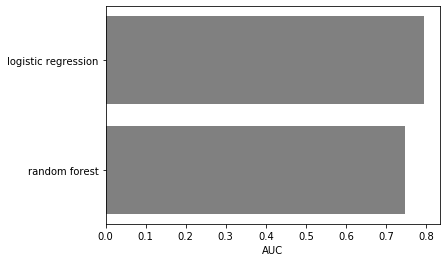

In [13]:
mods = ['logistic regression',
       'random forest']
performance = [log_perf_cv['auc'],
               rf_perf_cv['auc']]
fig, ax = plt.subplots()
y_pos = np.arange(len(mods))
ax.barh(y_pos, performance, align='center', color='grey')
ax.set_yticks(y_pos)
ax.set_yticklabels(mods)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('AUC')
plt.show()
auc_df = pd.DataFrame({'model':mods, 'auc':performance})
auc_df.to_csv('../data/for_plotting/auc_comparison.csv', index=False)

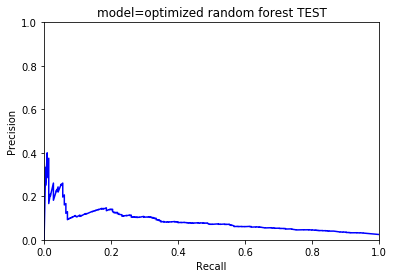

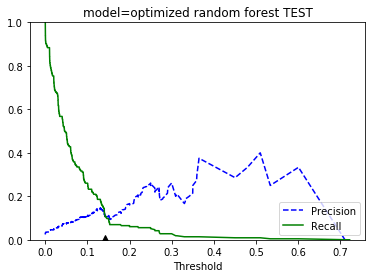

Confusion matrix for threshold = 0.14:
[[8386  191]
 [ 192   23]]
Classification report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      8577
           1       0.11      0.11      0.11       215

    accuracy                           0.96      8792
   macro avg       0.54      0.54      0.54      8792
weighted avg       0.96      0.96      0.96      8792



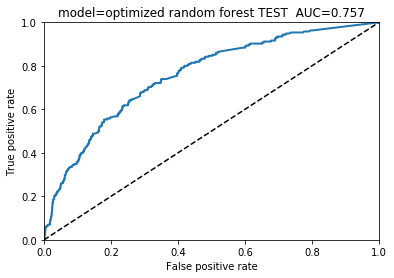

Confusion matrix for threshold = 0.04:
[[6879 1698]
 [  94  121]]
Classification report:
              precision    recall  f1-score   support

           0       0.99      0.80      0.88      8577
           1       0.07      0.56      0.12       215

    accuracy                           0.80      8792
   macro avg       0.53      0.68      0.50      8792
weighted avg       0.96      0.80      0.87      8792



In [16]:
#predict for test set
test_scores = rf_opt.predict_proba(X_test)[:, 1]
test_perf = get_model_performance('optimized random forest TEST', X_test, test_scores, y_test, pos_label=1)


threshold = 0.04
opt_pred = (test_scores > threshold).astype('int')
y_num = (y_test==1).astype('int')
print('Confusion matrix for threshold = {}:'.format(round(threshold, 2)))
cm = confusion_matrix(y_num, opt_pred)
print(cm)
print('Classification report:')
print(classification_report(y_num, opt_pred))